# Analyzing wildfire activities in Australia

## Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
%matplotlib inline

## Get the data

In [8]:
import requests
import io

URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Historical_Wildfires.csv"
response = requests.get(URL)
df = pd.read_csv(io.StringIO(response.text))
print('Data read into a pandas dataframe!')

Data read into a pandas dataframe!


## Check the data 

In [9]:
df.head()


,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,1/4/2005,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,1/5/2005,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,1/6/2005,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,1/7/2005,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,1/8/2005,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


In [10]:
df.columns

Index(['Region', 'Date', 'Estimated_fire_area',
       'Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power',
       'Mean_confidence', 'Std_confidence', 'Var_confidence', 'Count',
       'Replaced'],
      dtype='object')

In [11]:
df.dtypes

Region                                  object
Date                                    object
Estimated_fire_area                    float64
Mean_estimated_fire_brightness         float64
Mean_estimated_fire_radiative_power    float64
Mean_confidence                        float64
Std_confidence                         float64
Var_confidence                         float64
Count                                    int64
Replaced                                object
dtype: object

## Add two columns year and month

In [12]:
import datetime as dt

df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month


In [14]:
df.dtypes

Region                                  object
Date                                    object
Estimated_fire_area                    float64
Mean_estimated_fire_brightness         float64
Mean_estimated_fire_radiative_power    float64
Mean_confidence                        float64
Std_confidence                         float64
Var_confidence                         float64
Count                                    int64
Replaced                                object
Year                                     int32
Month                                    int32
dtype: object

## understanding the change in average estimated fire area over time

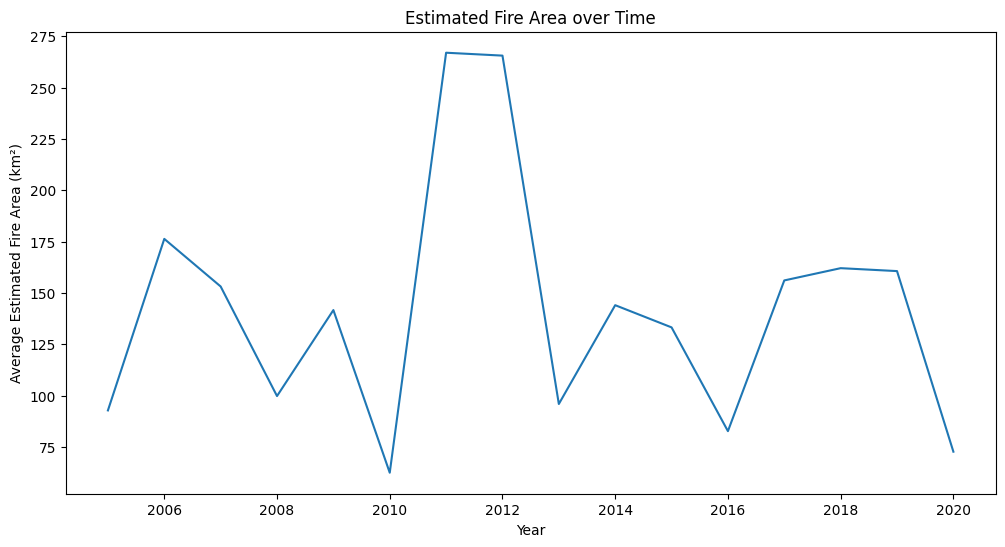

In [17]:
plt.figure(figsize=(12, 6))
df_new=df.groupby('Year')['Estimated_fire_area'].mean()
df_new.plot(x=df_new.index, y=df_new.values)
plt.xlabel('Year')
plt.ylabel('Average Estimated Fire Area (km²)')
plt.title('Estimated Fire Area over Time')
plt.show()

## We can notice a peak in the plot between 2010 to 2013. Let's narrow down our finding, by plotting the estimated fire area for year grouped together with month.

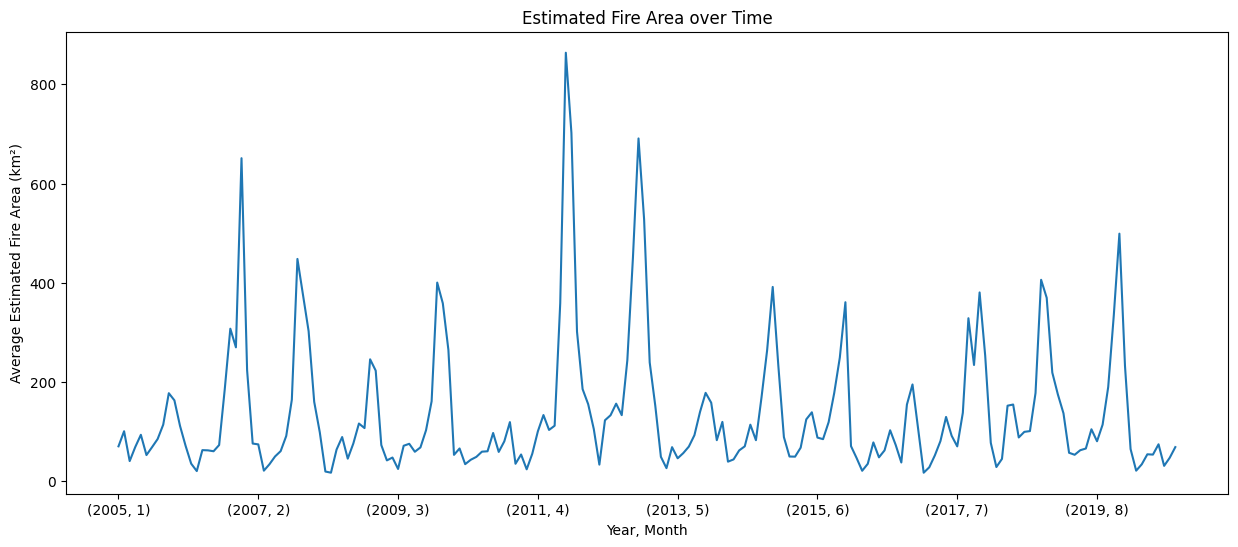

In [19]:
plt.figure(figsize=(15,6))
df_new=df.groupby(['Year','Month'])['Estimated_fire_area'].mean()
df_new.plot(x=df_new.index, y=df_new.values)
plt.xlabel('Year, Month')
plt.ylabel('Average Estimated Fire Area (km²)')
plt.title('Estimated Fire Area over Time')
plt.show()

## Insights on the distribution of mean estimated fire brightness across the regions

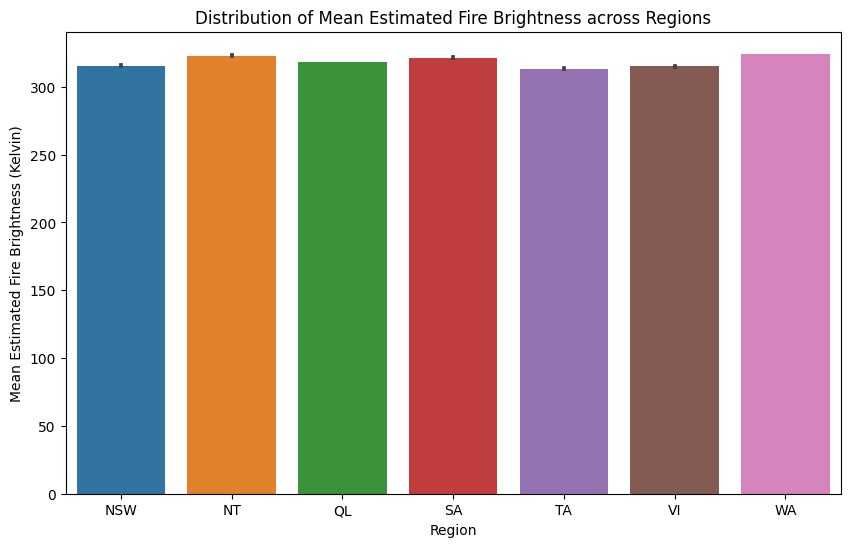

In [20]:
df['Region'].unique()
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Region', y='Mean_estimated_fire_brightness')
plt.xlabel('Region')
plt.ylabel('Mean Estimated Fire Brightness (Kelvin)')
plt.title('Distribution of Mean Estimated Fire Brightness across Regions')
plt.show()

## Portion of count of pixels for presumed vegetation fires vary across regions

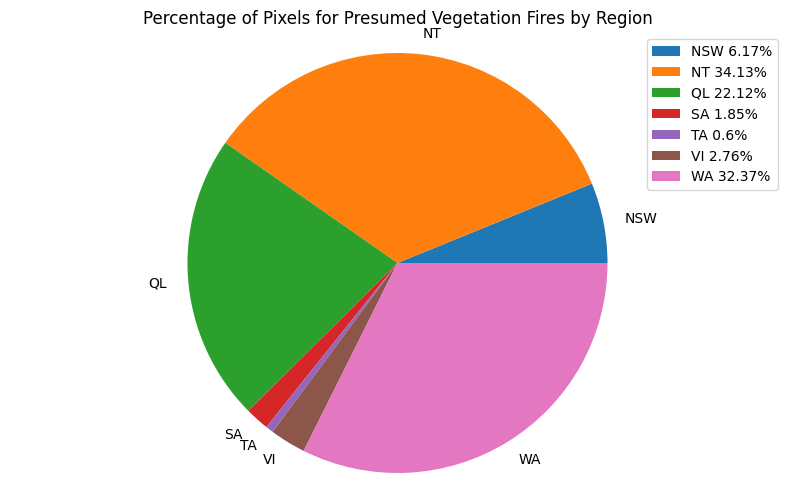

In [23]:
plt.figure(figsize=(10, 6))
region_counts = df.groupby('Region')['Count'].sum()
plt.pie(region_counts, labels=region_counts.index)
plt.title('Percentage of Pixels for Presumed Vegetation Fires by Region')
plt.legend([f'{i} {round(k/region_counts.sum()*100,2)}%' for i,k in zip(region_counts.index, region_counts)])
plt.axis('equal')
plt.show()

## histogram of the mean estimated fire brightness

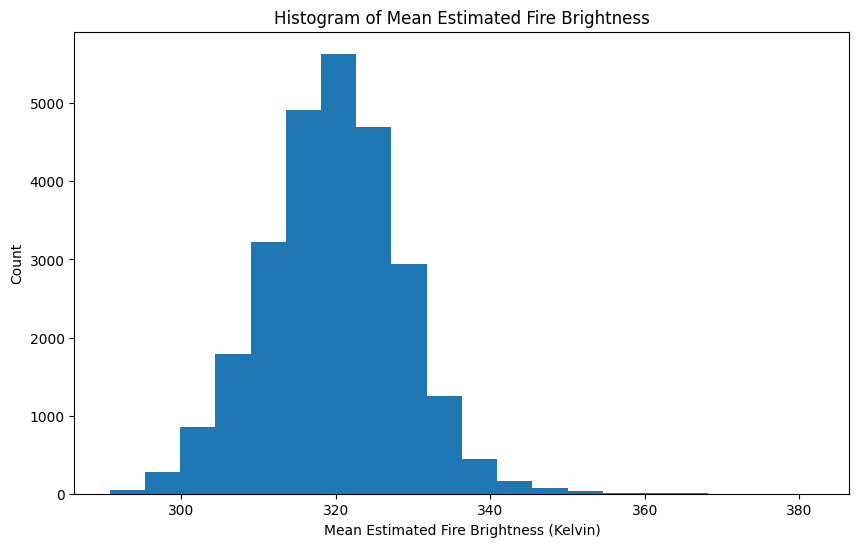

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(x=df['Mean_estimated_fire_brightness'], bins=20)
plt.xlabel('Mean Estimated Fire Brightness (Kelvin)')
plt.ylabel('Count')
plt.title('Histogram of Mean Estimated Fire Brightness')
plt.show()

## We need to understand the distribution of estimated fire brightness across regions. So we will use the functionality of seaborn and pass region as hue.

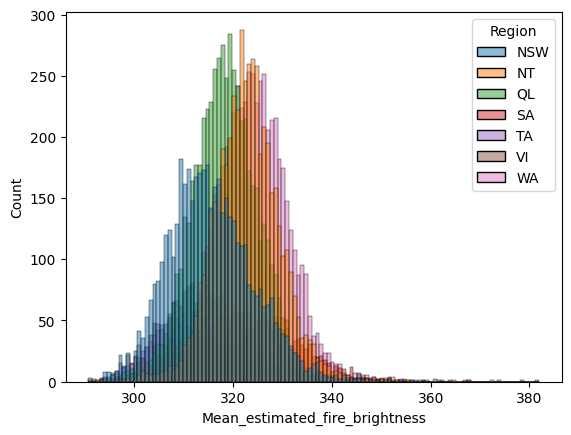

In [25]:
sns.histplot(data=df, x='Mean_estimated_fire_brightness', hue='Region')
plt.show()

## Using multiple='stack' to look better

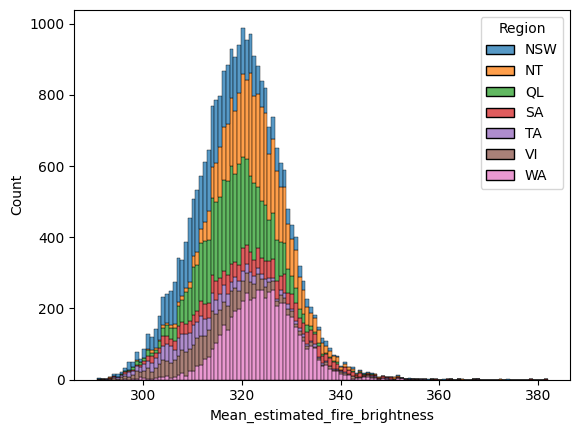

In [26]:
sns.histplot(data=df, x='Mean_estimated_fire_brightness', hue='Region', multiple='stack')
plt.show()

## To see if there is any correlation between mean estimated fire radiative power and mean confidence level

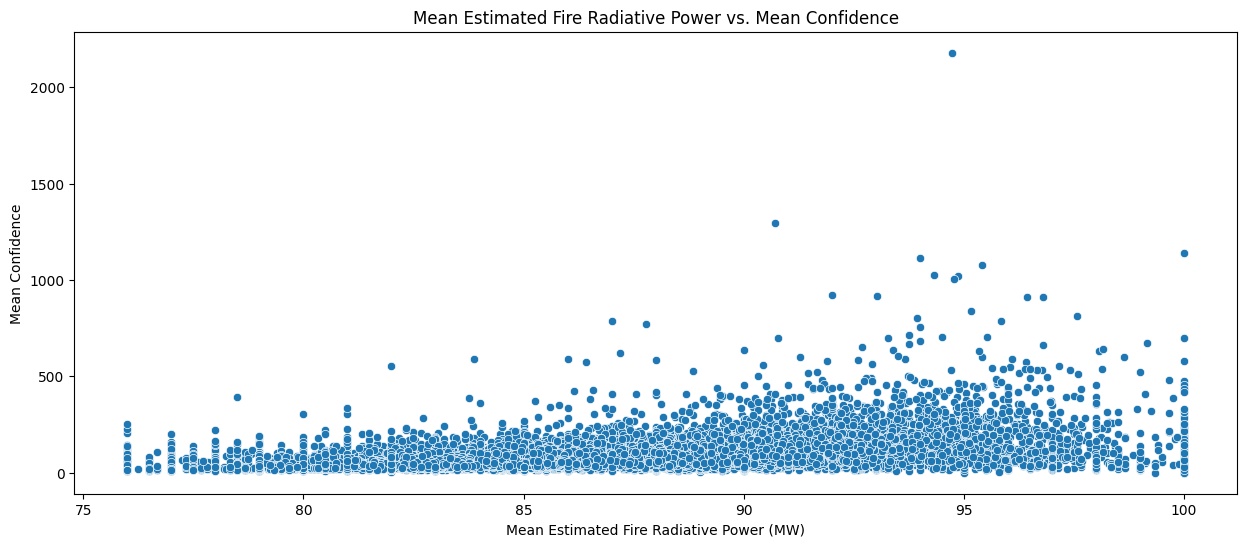

In [28]:
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df, x='Mean_confidence', y='Mean_estimated_fire_radiative_power')
plt.xlabel('Mean Estimated Fire Radiative Power (MW)')
plt.ylabel('Mean Confidence')
plt.title('Mean Estimated Fire Radiative Power vs. Mean Confidence')
plt.show()

## Give the location of all 7 regions of australia

In [29]:
region_data = {'region':['NSW','QL','SA','TA','VI','WA','NT'], 'Lat':[-31.8759835,-22.1646782,-30.5343665,-42.035067,-36.5986096,-25.2303005,-19.491411], 
               'Lon':[147.2869493,144.5844903,135.6301212,146.6366887,144.6780052,121.0187246,132.550964]}
reg=pd.DataFrame(region_data)
reg

,region,Lat,Lon
0,NSW,-31.875984,147.286949
1,QL,-22.164678,144.584490
2,SA,-30.534367,135.630121
3,TA,-42.035067,146.636689
4,VI,-36.598610,144.678005
5,WA,-25.230300,121.018725
6,NT,-19.491411,132.550964


## Mark these seven regions on the Map of Australia using Folium

In [33]:
aus_reg = folium.map.FeatureGroup()
Aus_map = folium.Map(location=[-25, 135], zoom_start=4)
for lat, lng, lab in zip(reg.Lat, reg.Lon, reg.region):
    aus_reg.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            popup=lab,
            radius=5,
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
Aus_map.add_child(aus_reg)

In [4]:
import pandas as pd
import dash
from dash import html, dcc
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import plotly.express as px
from dash import no_update
import datetime as dt

## Made by - Gruhit Kaneriya
## Roll No. - RA2211003010041